<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/2_GRU_Time_Series_Ejercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

#GRU en series temporales: Ejercicio

Para este ejercicio vamos a utilizar los datos de la Base de Datos Económicos de la Reserva Federal (FRED) relativos a la producción de los servicios públicos de electricidad y gas desde enero de 1992 hasta enero de 2019 (325 registros).

Fuente de datos: https://fred.stlouisfed.org/series/IPG2211A2N

El ejercico consta de las siguientes partes:
* Realizar importaciones estándar, cargar y trazar el conjunto de datos (código proporcionado)
* Preparar los datos para un modelo GRU
* Definir el modelo GRU y las funciones de pérdida y optimización
* Entrenar el modelo
* Evaluar el modelo en datos de prueba
* Graficar los resultados


## Realiza las importaciones estándar, carga y traza el conjunto de datos
Ejecute las celdas siguientes para cargar las bibliotecas necesarias para este ejercicio y el conjunto de datos de producción de energía, y para trazar los datos.

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('/content/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


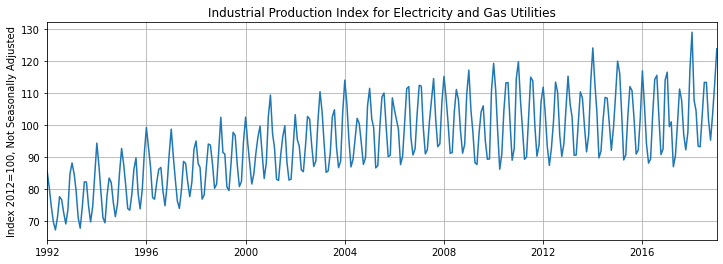

In [2]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

## Preparar los datos
Para el primer conjunto de ejercicios vamos a
* dividir los datos en conjuntos de entrenamiento y de prueba
* normalizaremos el conjunto de entrenamiento
* preparar las tuplas de secuencias/etiquetas con ventanas para un modelo GRU

## Dividir los datos en conjuntos de entrenamiento y de prueba
Trabajando con un tamaño de ventana de 12, dividir el conjunto de datos en una secuencia de 313 registros de entrenamiento (incluyendo la ventana), y un conjunto de prueba de 12 registros.

In [5]:
# Tu código aquí
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [6]:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


## Normalizar el conjunto de entrenamiento
Escala el conjunto de entrenamiento para que se ajuste al rango [-1,1].

In [7]:
# Tu código aquí
scaler = MinMaxScaler(feature_range=(-1, 1))


train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [8]:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


##Preparar los datos para la GRU
Prepare la lista de tuplas de secuencia/etiqueta con ventana para alimentar un modelo GRU.

In [9]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [10]:
# Tu código aquí

train_data = input_data(train_norm,window_size)
len(train_data)

301

In [11]:
print(f'Train_data: {len(train_data)}')  

Train_data: 301


## Definir el modelo
Diseñe un modelo que tenga una capa GRU (1,64) y una capa lineal totalmente conectada (64,1). Asegúrese de inicializar $h_0$, y devolver sólo el último valor predicho.

In [14]:
# Tu código aquí
class GRUnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Capa GRU:
        self.gru = nn.GRU(input_size,hidden_size)
             
        # Capa fully-connected:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialización h0:
        self.hidden = (torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        gru_out, self.hidden = self.gru(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(gru_out.view(len(seq),-1))
        return pred[-1]  # solo queremos el último valor
    
    



In [15]:

torch.manual_seed(101)
model = GRUnetwork()
model

GRUnetwork(
  (gru): GRU(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## Definir las funciones de pérdida y optimización
Defina una función de pérdida llamada "criterio" y un optimizador llamado "optimizador".<br>
Puedes utilizar las funciones que quieras, aunque nosotros hemos utilizado MSELoss y Adam (tasa de aprendizaje de 0,001) respectivamente.

In [16]:
# Tu código aquí
torch.manual_seed(101)
model = GRUnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



##Entrena el modelo
No se preocupe por el seguimiento de los valores de pérdida, la visualización de los resultados o la validación del conjunto de pruebas. Simplemente entrene el modelo a través de 50 épocas. Evaluaremos el modelo entrenado en el siguiente paso.

*CONSEJO: imprimir algo después de cada epoch para indicar el progreso del entrenamiento.*

In [17]:
# Tu código aquí
epochs = 50

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extraemos secuencia y label de los training data
    for seq, y_train in train_data:
        
        # reseteo de parametros ay estados ocultos
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # Imprimo log
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')



Epoch:  1 Loss: 0.45361468
Epoch:  2 Loss: 0.20118393
Epoch:  3 Loss: 0.20125441
Epoch:  4 Loss: 0.18778506
Epoch:  5 Loss: 0.17783125
Epoch:  6 Loss: 0.17018268
Epoch:  7 Loss: 0.16351058
Epoch:  8 Loss: 0.15728122
Epoch:  9 Loss: 0.15126267
Epoch: 10 Loss: 0.14534263
Epoch: 11 Loss: 0.13949400
Epoch: 12 Loss: 0.13377029
Epoch: 13 Loss: 0.12828352
Epoch: 14 Loss: 0.12315298
Epoch: 15 Loss: 0.11845170
Epoch: 16 Loss: 0.11418191
Epoch: 17 Loss: 0.11028592
Epoch: 18 Loss: 0.10667781
Epoch: 19 Loss: 0.10327297
Epoch: 20 Loss: 0.10000748
Epoch: 21 Loss: 0.09684757
Epoch: 22 Loss: 0.09378821
Epoch: 23 Loss: 0.09084721
Epoch: 24 Loss: 0.08805480
Epoch: 25 Loss: 0.08544357
Epoch: 26 Loss: 0.08304084
Epoch: 27 Loss: 0.08086461
Epoch: 28 Loss: 0.07892366
Epoch: 29 Loss: 0.07721856
Epoch: 30 Loss: 0.07574525
Epoch: 31 Loss: 0.07449711
Epoch: 32 Loss: 0.07346828
Epoch: 33 Loss: 0.07265436
Epoch: 34 Loss: 0.07205239
Epoch: 35 Loss: 0.07166024
Epoch: 36 Loss: 0.07147469
Epoch: 37 Loss: 0.07148923
E

## Evalúa el modelo utilizando el conjunto de pruebas
Asegúrese de reinicializar los parámetros ocultos $h_0$ antes de ejecutar el modelo.

In [18]:
# Tu código aquí
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())


In [19]:
preds[window_size:]

[0.2607552707195282,
 0.004351362586021423,
 -0.3481554388999939,
 -0.20015619695186615,
 0.1952650398015976,
 0.428867369890213,
 0.2577767074108124,
 -0.04681815207004547,
 -0.2652979791164398,
 0.06063850596547127,
 0.6297503709793091,
 0.6793975830078125]

## Transformación inversa de los valores predichos
Reescalar los valores predichos hasta el rango original del conjunto de pruebas.

In [20]:
# Tu código aquí
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [21]:
true_predictions

array([[106.16460553],
       [ 98.27646749],
       [ 87.431772  ],
       [ 91.98489468],
       [104.14983132],
       [111.3364902 ],
       [106.07297152],
       [ 96.70226296],
       [ 89.98084032],
       [100.00811332],
       [117.51655529],
       [119.04392694]])

## Graficar el resultado
Trace los valores de true_predictions junto con los datos originales. Recuerde crear un rango de valores de fecha para los datos predichos.

In [29]:
# Tu código aquí

# Recuerda que la fecha de parada tiene que ser posterior al último valor previsto.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')



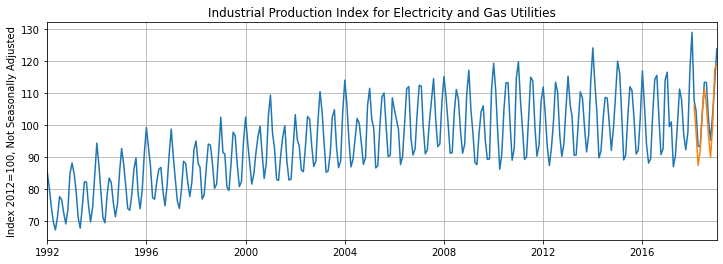

In [30]:
# Tu código aquí 
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

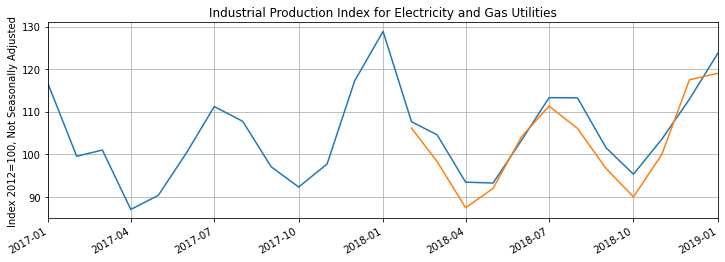

In [31]:

# Ploteamos la parte final del gráfico (zoom)
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Seleccionamos a partir de 01-01-2017:
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

¿Que te parecen los resultados? ¿Son mejorables? ¿Como? 
Prueba diferentes posibilidades y observa los resultados

Enhorabuena, has llegado al final del cuaderno. 


## Referencias

*   Documento inspirado en el curso UDEMY: DeepLearning con Pytorch de Jose Marcial Portilla.
* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Fin del cuaderno